<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/Beta_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beta Variational Auto-Encoder:
https://openreview.net/forum?id=Sy2fzU9gl

## Installations

In [0]:
%%capture
!pip install tqdm six

## Connect to Google Drive

In [3]:
from google.colab import drive

drive.mount("/content/drive")


%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Masters-DS/CSCI-B659/project
data/  dsprites-dataset/  examples/  results/


## Import

In [0]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
!git clone https://github.com/dawnJ/dsprites-dataset.git

Cloning into 'dsprites-dataset'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.


## Data

In [5]:
# Load dataset
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
 

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='latin1')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)


Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']
Metadata: 
 {'date': 'April 2017', 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', 'version': 1, 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY'), 'latents_possible_values': {'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.3832536

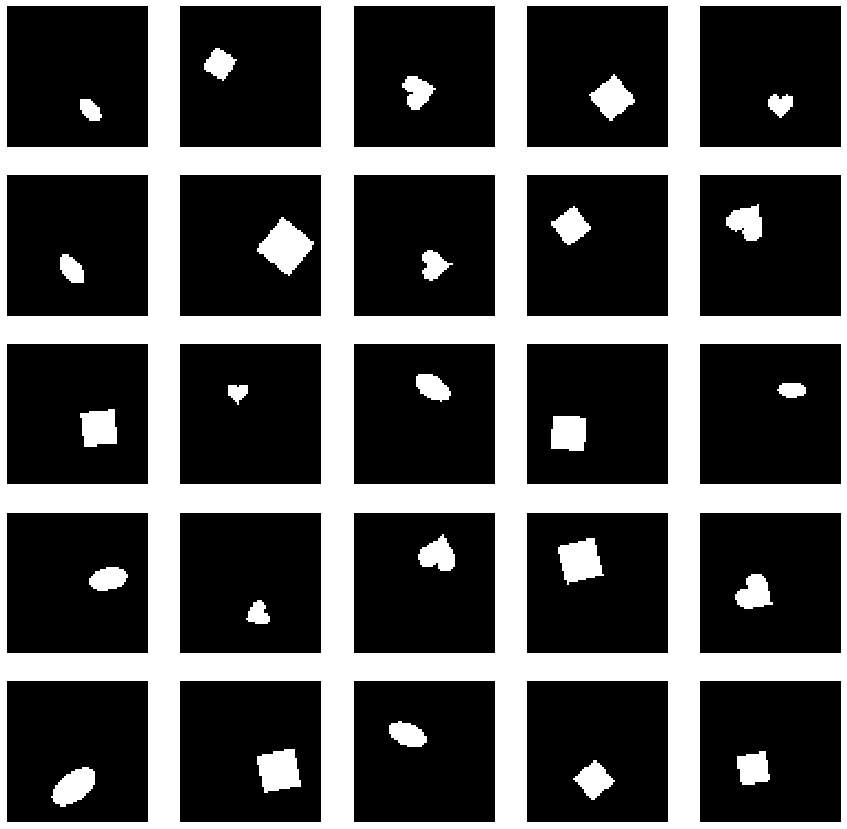

In [5]:
# Helper function to show images

# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')
      
def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

# Sample latents randomly
latents_sampled = sample_latent(size=200)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled)


In [20]:
print("Total number of images",len(imgs))

imgs = imgs[:2000]

Total number of images 737280


In [0]:
#print("Latent",latents_sizes)

## DataLoader

In [0]:

params = {
    "batch_size":128,
    "eta":1e-2, # learning rate for adagrad
    "beta":4,
    "nb_latents":10,
    "epochs":100,
    "seed":1,
    "log_interval":100,
    "save_interval":1000

}

from torch.utils.data import Dataset, DataLoader


class SpritesDataset(Dataset):
  def __init__(self):
    dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='latin1')
    self.imgs = dataset_zip['imgs']
    
  def __len__(self):
    return self.imgs.shape[0]
  
  def __getitem__(self,idx):
    return self.imgs[idx].astype(np.float32)
  
"""
Construct dataloader to return images
"""
def get_dataloader(batchsize,shuffle=True):
  sprites_dataset = SpritesDataset()
  return DataLoader(sprites_dataset, batch_size=params.get("batch_size"), shuffle=shuffle)



## Models

In [0]:
## DenseVAE

from torch import nn
from torch.autograd import Variable

class DenseVAE(nn.Module):
  def __init__(self,nb_latents):
    super(DenseVAE,self).__init__()
    
    ## Define network
    self.fc1 = nn.Linear(4096,1200)
    self.fc2 = nn.Linear(1200,1200)
    
    ## encode
    self.fc_mean = nn.Linear(1200, nb_latents)
    self.fc_std = nn.Linear(1200,nb_latents)
    
    # decode
    self.fc3 = nn.Linear(nb_latents,1200)
    self.fc4 = nn.Linear(1200, 1200)
    self.fc5 = nn.Linear(1200,1200)
    self.fc6 = nn.Linear(1200,4096)
    
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()
  
  """
  ENCODE INTO TWO LATENT VECTORS - MEAN AND STD
  """
  def encode(self,x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    
    
    return self.fc_mean(x), self.fc_std(x)
  
  """
  Reparametrize 
  """
  def reparametrize(self, mu, logvar):
    if self.training:
      std = logvar.mul(0.5).exp_()
      eps = Variable(std.data.new(std.size()).normal_())
      return eps.mul(std).add_(mu)
    
    else:
      return mu
    
    
  """
  Decode
  """
  def decode(self,z):
    x = self.tanh(self.fc3(z))
    x = self.tanh(self.fc4(x))
    x = self.tanh(self.fc5(x))
    return self.sigmoid(self.fc6(x))
  
  
  """
  Forward
  """
  def forward(self,x):
    mu, logvar = self.encode(x.view(-1,64*64))
    z = self.reparametrize(mu,logvar)
    return self.decode(z),mu, logvar
  
  
  
    

In [0]:
class ConvVAE(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(64*4*4, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 64*4*4)
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
    
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.fc1(x.view(-1, 64*4*4)))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 4, 4)))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        return self.sigmoid(self.deconv4(x))
        
    def forward(self, x):
        mu, logvar = self.encode(x.unsqueeze(1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Training

In [0]:
## make directory results if it doesnt exist
import os 
import shutil

import time



def make_results():
  if os.path.isdir("results"):
    shutil.rmtree("results")
  os.makedirs("results")
  
  
def loss_function(recon_x, x, mu, logvar,beta):
  """
  Reconstruction loss  + KL divergence loss over all elements of the batch
  """
  bce = F.binary_cross_entropy(recon_x, x.view(-1, 64*64), size_average=False)
  
  kld = -0.5* (1+ logvar -mu.pow(2) -  logvar.exp())
  return kld.mean(dim = 0), bce + beta*kld.sum()
  
"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath="results"):
  model.eval()
  
  if isinstance(model,ConvVAE):
    datapoint = datapoint.unsqueeze(0).unsqueeze(1)
    mu, _ = model.encode(datapoint)
  else:
    mu, _ = model.encode(datapoint.view(-1))
  
  recons = torch.zeros((7, nb_latents, 64, 64))
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val
      recon = model.decode(muc).cpu()
      recons[i, zi] = recon.view(64, 64)

  filename = os.path.join(dirpath, 'traversal_' + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 64, 64), filename, nrow=nb_latents, pad_value=1)
  
  
  
def train():
  ## make results dir - if it doesnt exist
  make_results()
  
  ## dataloader
  dataloader = get_dataloader(params.get("batch_size"))
  testpoint = torch.Tensor(dataloader.dataset[0])
  
  
  model = DenseVAE(params.get("nb_latents"))
  optimizer = optim.Adagrad(model.parameters(), lr=params.get("eta"))

  model.train()
  
  runningloss, runningkld = None, np.array([])
  start_time = time.time()
  
  for epoch in range(1, params.get("epochs")+1):
    for batch_idx, data in enumerate(dataloader):
      recon_batch, mu, logvar = model(data)
      
      kld, loss = loss_function(recon_batch, data, mu, logvar,params.get("beta"))
      
      
      ## parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      loss /=len(data)
      runningloss = loss if not runningloss else runningloss*0.99 + loss*0.01
      
      runningkld =  np.zeros(params.get("nb_latents")) if not len(runningkld) else runningkld*0.99 + kld.data.cpu().numpy()*0.01
      if not batch_idx % params.get("log_interval"):
                print("Epoch {}, batch: {}/{} ({:.2f} s), loss: {:.2f}, kl: [{}]".format(
                    epoch, batch_idx, len(dataloader), time.time() - start_time, runningloss, 
                    ", ".join("{:.2f}".format(kl) for kl in runningkld)))
                start_time = time.time()

      if not batch_idx % params.get("save_interval"):
          traverse_latents(model, testpoint, params.get("nb_latents"), epoch, batch_idx)
          model.train()

  

In [12]:
params

{'batch_size': 128,
 'beta': 4,
 'epochs': 100,
 'eta': 0.01,
 'log_interval': 100,
 'nb_latents': 10,
 'save_interval': 1000,
 'seed': 1}

In [0]:
train()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1, batch: 0/5760 (0.45 s), loss: 2842.03, kl: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
Epoch 1, batch: 100/5760 (36.12 s), loss: 1600.24, kl: [5.82, 4.64, 9.43, 5.10, 3.91, 5.19, 2.71, 6.21, 5.94, 4.21]
Epoch 1, batch: 200/5760 (35.40 s), loss: 790.05, kl: [2.96, 2.40, 4.06, 2.23, 1.79, 2.60, 1.37, 3.34, 2.41, 2.23]
Epoch 1, batch: 300/5760 (35.24 s), loss: 461.20, kl: [2.10, 1.77, 2.14, 1.22, 0.93, 1.71, 0.79, 2.57, 1.10, 1.69]
Epoch 1, batch: 400/5760 (35.32 s), loss: 319.81, kl: [1.83, 1.79, 1.49, 0.86, 0.48, 1.43, 0.45, 2.48, 0.58, 1.58]
Epoch 1, batch: 500/5760 (35.60 s), loss: 253.97, kl: [1.72, 1.95, 1.24, 0.70, 0.24, 1.24, 0.24, 2.58, 0.33, 1.62]
Epoch 1, batch: 600/5760 (35.42 s), loss: 221.65, kl: [1.68, 2.04, 1.11, 0.61, 0.12, 1.12, 0.14, 2.67, 0.19, 1.68]
Epoch 1, batch: 700/5760 (34.99 s), loss: 203.91, kl: [1.67, 2.10, 1.03, 0.49, 0.07, 0.99, 0.09, 2.75, 0.10, 1.77]
Epoch 1, batch: 800/5760 (35.13 s), loss: 193.26, kl: [1.66, 2.16, 0.96, 0.37, 0.

In [0]:
%ls results